In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/0.data/heart_2020_final.csv')
X = df.iloc[:,1:].values
y = df['HeartDisease']

# 각 모델별로 Accuracy를 비교해본 시각화자료

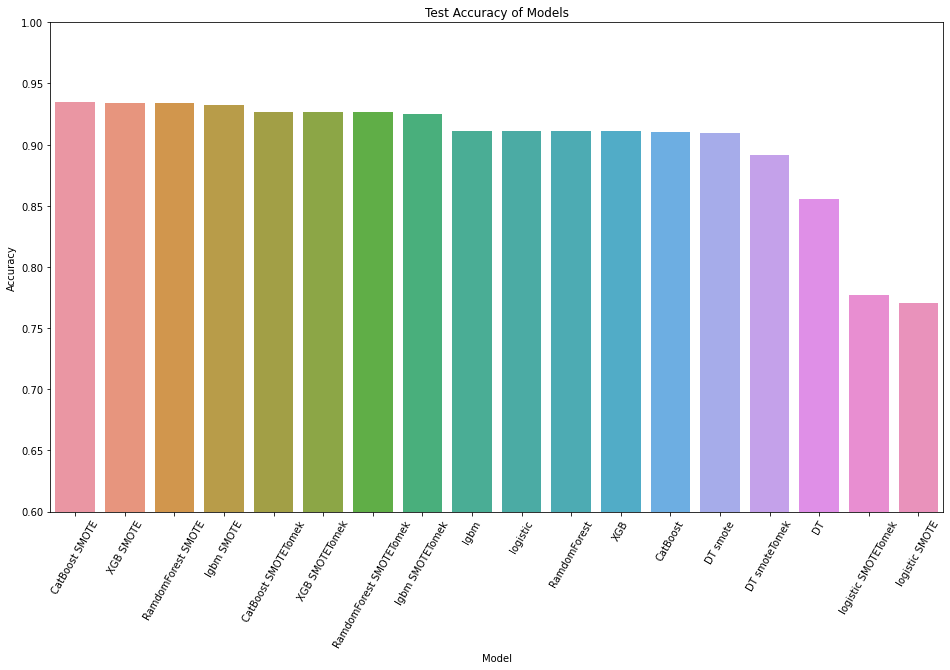

In [ ]:
df = pd.DataFrame({'model': ['DT', 'DT smote', 'DT smoteTomek', 'XGB', 'XGB SMOTE', 'XGB SMOTETomek', 'RamdomForest', 'RamdomForest SMOTE', 'RamdomForest SMOTETomek', 'logistic', 'logistic SMOTE', 'logistic SMOTETomek', 'lgbm', 'lgbm SMOTE', 'lgbm SMOTETomek', 'CatBoost', 'CatBoost SMOTE', 'CatBoost SMOTETomek'], 
                   'test_acc': [0.8558748683717357, 0.9093151534570472, 0.891845650288122, 0.9107640526878067, 0.9342426484002667, 0.9264283547170615, 0.9107640526878067, 0.9342426484002667, 0.9264283547170615, 0.9112711513982413, 0.7705533859769023, 0.7774134444563707, 0.9114766420727254, 0.9322951590251705, 0.9248841876122424, 0.9104226737763377, 0.9349294605881056, 0.9268094771858021]})
df = df.sort_values(by = 'test_acc',ascending = False)
plt.figure(figsize = (16,9))
plt.xticks(rotation=60)
sns.barplot(df['model'], df['test_acc'])
plt.ylim([0.6, 1.0])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Test Accuracy of Models")
plt.show()

# train test 과적합 여부를 확인하기 위한 시각화

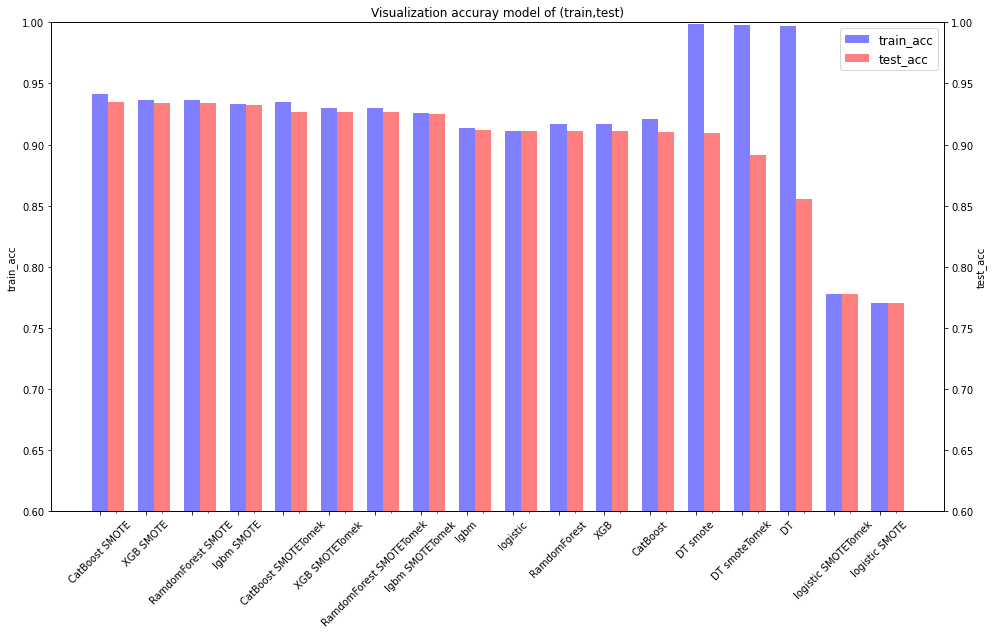

<Figure size 7200x7200 with 0 Axes>

In [ ]:
# train , test 데이터 과적합 여부를 확인하기 위한 시각화
df = pd.DataFrame({'model': ['DT', 'DT smote', 'DT smoteTomek', 'XGB', 'XGB SMOTE', 'XGB SMOTETomek', 'RamdomForest', 'RamdomForest SMOTE', 'RamdomForest SMOTETomek', 'logistic', 'logistic SMOTE', 'logistic SMOTETomek', 'lgbm', 'lgbm SMOTE', 'lgbm SMOTETomek', 'CatBoost', 'CatBoost SMOTE', 'CatBoost SMOTETomek'], 
                   'test_acc': [0.8558748683717357, 0.9093151534570472, 0.891845650288122, 0.9107640526878067, 0.9342426484002667, 0.9264283547170615, 0.9107640526878067, 0.9342426484002667, 0.9264283547170615, 0.9112711513982413, 0.7705533859769023, 0.7774134444563707, 0.9114766420727254, 0.9322951590251705, 0.9248841876122424, 0.9104226737763377, 0.9349294605881056, 0.9268094771858021],
                   'train_acc' : [0.9969897288823768,0.9983453632079854,0.9977822213821248,0.9169329203898815,0.9366433051647263, 0.9295252915691382,0.9169329203898815,0.9366433051647263,0.9295252915691382,0.9112951867137333, 0.7706335442077693, 0.7775074604720674,0.9131379732256774, 0.9327797534287333, 0.9254952150686346, 0.920823155371569,0.9411786406235784 ,0.9343686376833384]})
df = df.sort_values(by = 'test_acc',ascending = False)

fig, ax3 = plt.subplots(figsize = (16,9)) # axes3 생성

bar_width = 0.35 # 막대 너비 설정
alpha = 0.5 # 투명도 설정
plt.figure(figsize = (100,100)) # figure 사이즈 설정
N = len(df) # p4 를 그릴 position 생성
index = np.arange(N)
ax3.set_ylabel("train_acc")
ax3.xaxis.set_tick_params(rotation=45) # ax3의 x 눈금 45도 각도로 출력
p3 = ax3.bar(df['model'],df['train_acc'], bar_width, alpha=alpha, color='b') # 노인 인구 수 bar
ax3.set_ylim([0.6,1]) # y축을 제한하여 표를 더 보기 좋게 만듬

ax4 = ax3.twinx() # axes3에 axes4를 겹쳐 생성
ax4.set_ylabel("test_acc")
ax4.set_xticks(index + bar_width, minor=True) # 다른 데이터프레임이라 p4의 x 눈금도 표시되는 것을 출력되지 않도록 설정
p4 = ax4.bar(index + bar_width, df['test_acc'], bar_width, alpha=alpha, color='r') # 노인 교통사고 발생 건수 bar, 설정한 p4 position에 그려지도록 입력
ax4.set_ylim([0.6,1])

ax3.legend((p3, p4), ('train_acc', 'test_acc'), fontsize = 12, loc='upper right') # 범례 입력
ax3.set_title("Visualization accuray model of (train,test)") # Title 입력

plt.show()

In [5]:
def fold_K(X, y, model):    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    acc_test_score = []
    acc_train_score = []
    rec_test_score = []
    rec_train_score = []
    
    for train_index, test_index in kf.split(X): # 5번
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        acc_train_score.append(accuracy_score(y_train,y_pred_train))
        acc_test_score.append(accuracy_score(y_test,y_pred))
        
        rec_test_score.append(recall_score(y_test , y_pred))
        rec_train_score.append(recall_score(y_train , y_pred_train))

    print('acc test score : {}'.format(np.array(acc_test_score).mean()))
    print('acc train score : {}'.format(np.array(acc_train_score).mean()))
    print('rec test score : {}'.format(np.array(rec_test_score).mean()))
    print('rec train score : {}'.format(np.array(rec_train_score).mean()))
    return model

In [6]:
smote = SMOTE(random_state = 42)
X_smote,y_smote = smote.fit_resample(X,y)

X_train_ns,y_train_ns = SMOTETomek(sampling_strategy=0.5).fit_resample(X,y)

# 데이터 학습

In [7]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf = fold_K(X_smote,y_smote,rf_clf)
xgb = XGBClassifier(random_state = 42)
xgb = fold_K(X_smote,y_smote,xgb)
cat = CatBoostClassifier(random_state = 42,verbose = 1000)
cat = fold_K(X_smote, y_smote, cat)

acc test score : 0.9364834423662398
acc train score : 0.9983257790125476
rec test score : 0.9143257853238629
rec train score : 0.9983012088200576
acc test score : 0.8972622200946233
acc train score : 0.8973373695653061
rec test score : 0.887230815911375
rec train score : 0.8874062524401476
Learning rate set to 0.138459
0:	learn: 0.6009830	total: 224ms	remaining: 3m 43s
999:	learn: 0.1450643	total: 2m 44s	remaining: 0us
Learning rate set to 0.138459
0:	learn: 0.5994557	total: 177ms	remaining: 2m 57s
999:	learn: 0.1449758	total: 2m 46s	remaining: 0us
Learning rate set to 0.138459
0:	learn: 0.5998099	total: 170ms	remaining: 2m 49s
999:	learn: 0.1449422	total: 2m 43s	remaining: 0us
Learning rate set to 0.138459
0:	learn: 0.5997890	total: 171ms	remaining: 2m 51s
999:	learn: 0.1446729	total: 3m 1s	remaining: 0us
Learning rate set to 0.138459
0:	learn: 0.6010789	total: 198ms	remaining: 3m 17s
999:	learn: 0.1455616	total: 2m 58s	remaining: 0us
acc test score : 0.9348875601124348
acc train scor

# RandomForest 특성 중요도 시각화

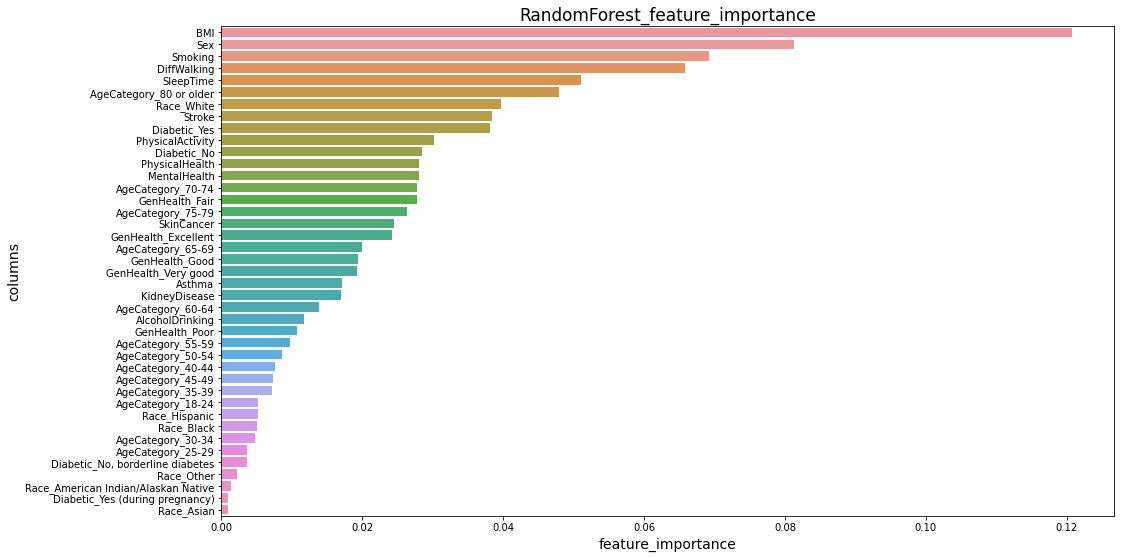

In [8]:

# RandomForest 특성중요도 시각화
data = pd.Series(rf_clf.feature_importances_,index = df.columns[1:]).sort_values(ascending = False)
plt.figure(figsize = (16,9))
plt.title('RandomForest_feature_importance',fontdict={'fontsize' : 17})
plt.xlabel('feature_importance',fontdict={'fontsize' : 14})
plt.ylabel('columns',fontdict={'fontsize' : 14})
sns.barplot(x = data.values,y =data.index)
plt.show()

# XGBoost 특성 중요도 시각화

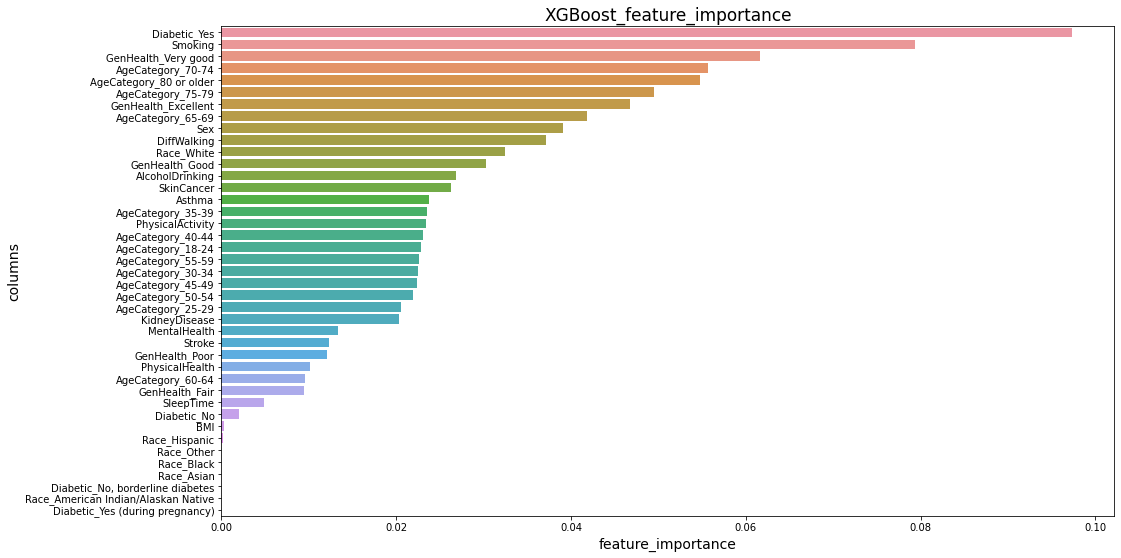

In [9]:


# XGBoost 특성중요도 시각화
data = pd.Series(xgb.feature_importances_,index = df.columns[1:]).sort_values(ascending = False)
plt.figure(figsize = (16,9))
plt.title('XGBoost_feature_importance',fontdict={'fontsize' : 17})
plt.xlabel('feature_importance',fontdict={'fontsize' : 14})
plt.ylabel('columns',fontdict={'fontsize' : 14})
sns.barplot(x = data.values,y =data.index)
plt.show()

# CatBoost 특성 중요도 시각화

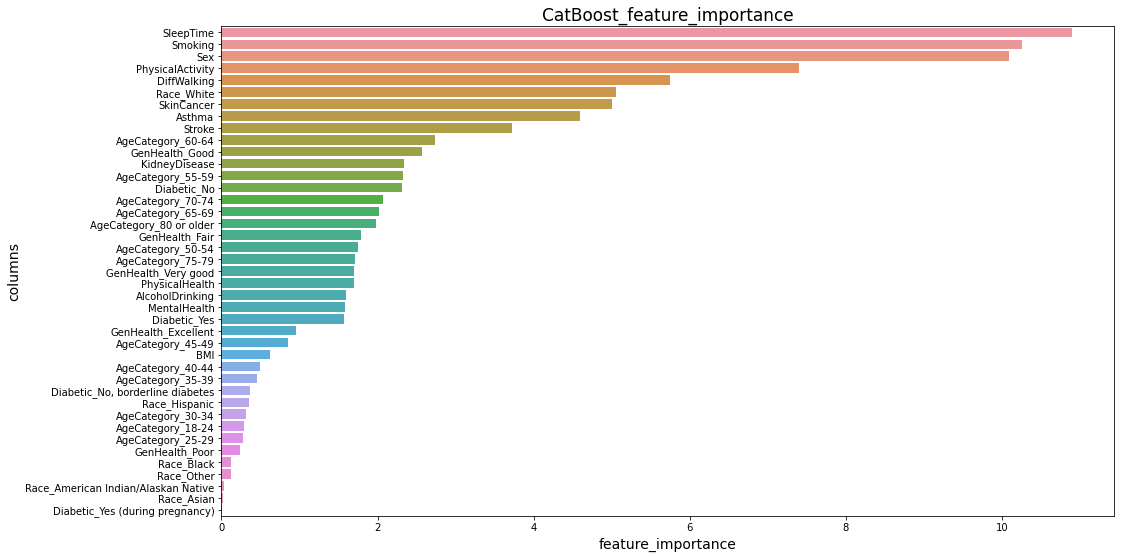

In [10]:

# catboost 특성중요도 시각화
data = pd.Series(cat.get_feature_importance(),index = df.columns[1:]).sort_values(ascending = False)
plt.figure(figsize = (16,9))
plt.title('CatBoost_feature_importance',fontdict={'fontsize' : 17})
plt.xlabel('feature_importance',fontdict={'fontsize' : 14})
plt.ylabel('columns',fontdict={'fontsize' : 14})
sns.barplot(x = data.values,y =data.index)
plt.show()